In [1]:
import numpyro
import numpy as np 
from jax import random

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [16]:
# Using ChatGPT to generate "fake" data for short heavy people

# Set the number of people
n_people = 30

# Generate true heights and weights
# Hyperprior for height (Mean = 145 cm, Std = 7 cm for short people)
heights_true = np.random.normal(loc=145, scale=7, size=n_people)  
# Hyperprior for weight (Mean = 85 kg, Std = 15 kg for heavy individuals)
weights_true = np.random.normal(loc=85, scale=15, size=n_people)   

# Add uncertainty to the observed heights and weights (±5 cm or kg uncertainty)
heights_observed = heights_true + np.random.randn(n_people) * 5  # Uncertainty in height (±5 cm)
weights_observed = weights_true + np.random.randn(n_people) * 5  # Uncertainty in weight (±5 kg)

# Display the data
data = list(zip(heights_observed, weights_observed))
data




[(156.52524826450025, 105.61421476064561),
 (149.82766019069604, 100.13496031595825),
 (131.2175706844292, 78.27451514482216),
 (166.10681176898106, 82.16324753187313),
 (138.8376001006796, 78.03449774457349),
 (132.20181201727584, 85.97361153623515),
 (142.3693953543967, 113.25183971859322),
 (138.15095701434828, 95.82968642099529),
 (136.6850099756047, 88.37716959703329),
 (140.8203239893205, 76.6341782960189),
 (150.89115237274672, 109.59297468860461),
 (153.22991544674932, 65.52202379951484),
 (133.61056084588637, 93.62993770256993),
 (154.27934081703154, 96.50275322241981),
 (132.86443778112172, 104.9662494461144),
 (126.90043352954528, 108.77651410668994),
 (136.6079595571337, 104.38624080968675),
 (142.1572534094455, 96.94015255253454),
 (139.52837842774443, 82.30821423240646),
 (137.95892185082516, 52.51266472826952),
 (138.95598143414034, 58.39369701834002),
 (146.90284154935208, 104.74807502008622),
 (133.12278131885424, 89.18330338845576),
 (153.96504124030145, 64.5608634735

In [17]:
def model(observed_ages=[]):
    with numpyro.plate('plate_i', n_people):
        height = numpyro.sample('height', dist.Normal(170, 10))
        weight = numpyro.sample('weight', dist.Normal(70, 15))
        
    if len(heights_observed) > 1 and len(weights_observed) > 1:
        with numpyro.plate('data', n_people):
        # Sample the observed heights and weights
            numpyro.sample('obs_height', dist.Normal(height, 5.0), obs=heights_observed)
            numpyro.sample('obs_weight', dist.Normal(weight, 5.0), obs=weights_observed)

In [18]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1442.06it/s, 7 steps of size 4.42e-01. acc. prob=0.90] 


array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'height'}>]], dtype=object)

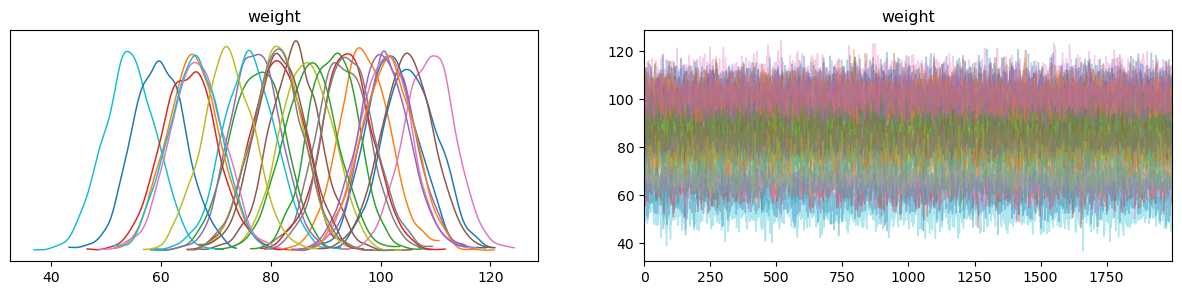

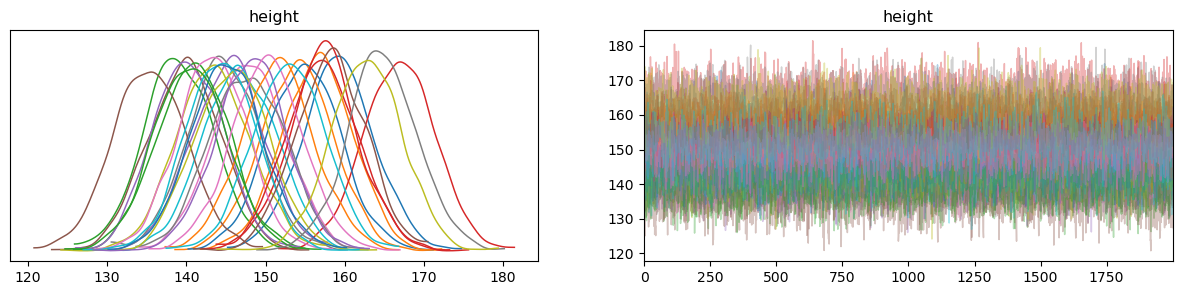

In [19]:
import arviz as az

# Assuming 'mcmc' is the result from your MCMC sampling
data = az.from_numpyro(mcmc)

# Plot the trace for both 'height' and 'weight'
az.plot_trace(data, var_names=['weight'], compact=True, figsize=(15, 3))
az.plot_trace(data, var_names=['height'], compact=True, figsize=(15, 3))


In [21]:
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1750.83it/s, 7 steps of size 4.42e-01. acc. prob=0.90] 


array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'height'}>]], dtype=object)

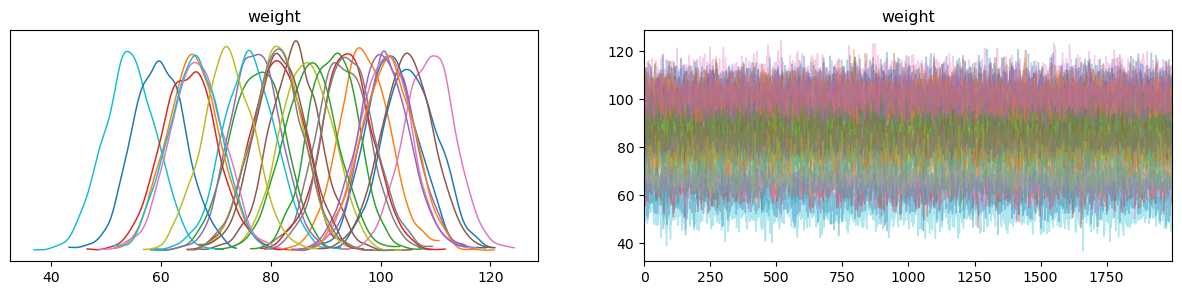

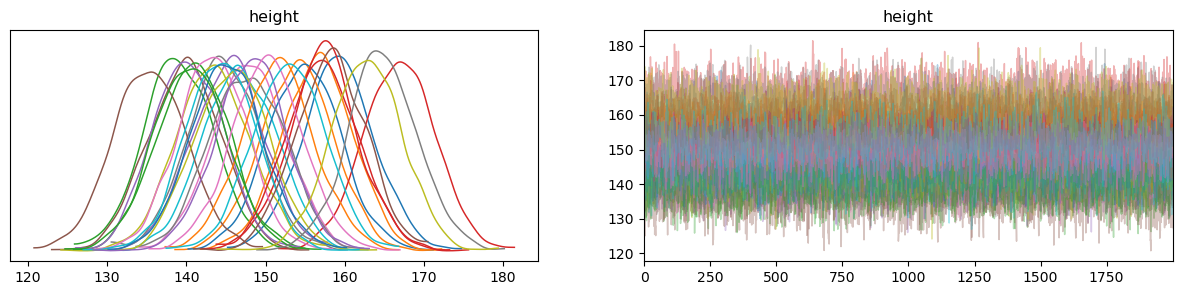

In [22]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, var_names=['weight'], compact=True, figsize=(15, 3))
az.plot_trace(data, var_names=['height'], compact=True, figsize=(15, 3))

In [36]:
def HBmodel(observed_ages=[]):
    mean_height = numpyro.sample('mean_height', dist.Normal(145, 7))
    mean_weight = numpyro.sample('mean_weight', dist.Normal(85, 15))
    
    with numpyro.plate('plate_i', n_people):
        height_ = numpyro.sample('height_', dist.Normal(mean_height, 1.0))
        weight_ = numpyro.sample('weight_', dist.Normal(mean_weight, 1.0))
        height = numpyro.deterministic('height', mean_height + height_)
        weight = numpyro.deterministic('weight', mean_weight + weight_)
        
    if len(heights_observed) > 1 and len(weights_observed) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs_height', dist.Normal(height, 5.0), obs=heights_observed)
            numpyro.sample('obs_weight', dist.Normal(weight, 5.0), obs=weights_observed)

In [37]:
nuts_kernel = NUTS(HBmodel)

hbm_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
hbm_mcmc.run(rng_key, data)

posterior_samples = hbm_mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:06<00:00, 1317.48it/s, 15 steps of size 3.05e-01. acc. prob=0.90]


In [38]:
hbm_mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   height_[0]     72.93      1.07     72.94     71.11     74.65   4131.92      1.00
   height_[1]     72.70      1.03     72.72     70.96     74.32   3869.53      1.00
   height_[2]     71.96      1.08     71.96     70.12     73.62   4035.55      1.00
   height_[3]     73.30      1.06     73.31     71.56     75.03   4413.15      1.00
   height_[4]     72.26      1.06     72.28     70.40     73.90   3761.79      1.00
   height_[5]     71.99      1.08     72.00     70.04     73.60   4544.61      1.00
   height_[6]     72.40      1.05     72.40     70.69     74.15   3899.77      1.00
   height_[7]     72.24      1.10     72.25     70.43     74.05   4070.81      1.00
   height_[8]     72.17      1.11     72.17     70.37     73.97   3997.88      1.00
   height_[9]     72.34      1.05     72.35     70.56     74.02   4161.90      1.00
  height_[10]     72.71      1.06     72.70     70.98     74.43   4238.09  

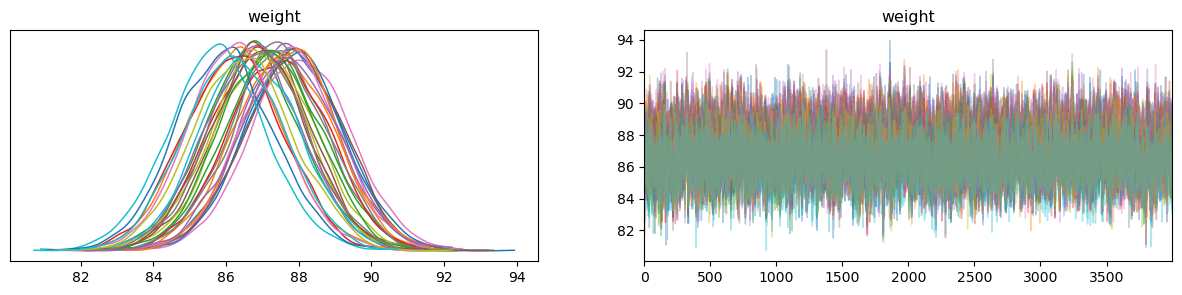

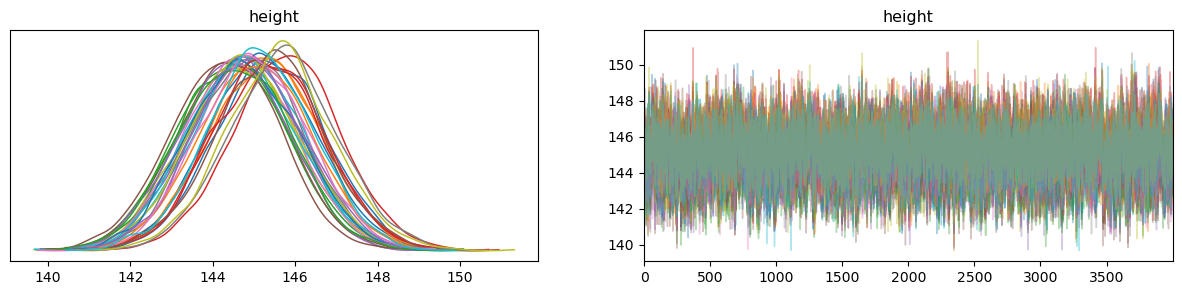

In [39]:
hbm_data = az.from_numpyro(hbm_mcmc)
az.plot_trace(hbm_data, var_names=['weight'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['height'], compact=True, figsize=(15, 3));
